# IMDB Results Analysis

In [1]:
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats
from scipy.spatial import distance

from compute_npmi import compute_npmi_at_n
import file_handling as fh

In [2]:
sentiment = pd.read_csv("../scholar/data/imdb/processed/train.sentiment.csv", index_col=0)
output_dirs = sorted(list(Path("./").glob("imdb-k_50/*")))

n_topics = 50
n_seeds = 15

In [4]:
metrics = {str(dir.name): pd.read_csv(Path(dir, "dev_metrics_50.csv")) for dir in output_dirs if dir.is_dir()}

column_to_compare = 'npmi_value'
ttest_results = pd.DataFrame(columns=metrics.keys(), index=metrics.keys())
for model_a in metrics:
    for model_b in metrics:
        stat, pval = stats.ttest_rel(
            metrics[model_a][column_to_compare],
            metrics[model_b][column_to_compare]
        )
        ttest_results.at[model_a, model_b] = pval
ttest_results

,baseline-learned_dev_learned_bg,baseline-learned_dev_no_bg-with_label,baseline-no_dev_learned_bg,baseline-no_dev_learned_bg-with_label,learned_dev_learned_bg,learned_dev_no_bg,learned_dev_no_bg-with_label
baseline-learned_dev_learned_bg,NaN,0.621834,0.138023,0.596885,0.746591,0.993837,0.269682
baseline-learned_dev_no_bg-with_label,0.621834,NaN,0.422955,0.983875,0.784358,0.619095,0.0664381
baseline-no_dev_learned_bg,0.138023,0.422955,NaN,0.320382,0.160461,0.156235,0.0091793
baseline-no_dev_learned_bg-with_label,0.596885,0.983875,0.320382,NaN,0.713917,0.572545,0.046887
learned_dev_learned_bg,0.746591,0.784358,0.160461,0.713917,NaN,0.78041,0.119745
learned_dev_no_bg,0.993837,0.619095,0.156235,0.572545,0.78041,NaN,0.201004
learned_dev_no_bg-with_label,0.269682,0.0664381,0.0091793,0.046887,0.119745,0.201004,NaN


In [5]:
thetas = {}
for dir in output_dirs:
    thetas[str(dir)] = {}
    for seeddir in dir.glob("[0-9]*"):
        theta = np.load(Path(seeddir, "theta.train.npz"))
        assert(np.all(theta['ids'] == sentiment.index))
        thetas[str(dir)][seeddir] = theta['theta']

In [8]:
thetas_by_sentiment = {}
abs_diffs = {}
for model, theta_by_seed in thetas.items():
    if not theta_by_seed:
        continue
    
    abs_diffs[model] = np.array([])
    for theta in theta_by_seed.values():
        theta_sent = np.array([
            theta[sentiment['neg'] == 1].mean(0),
            theta[sentiment['pos'] == 1].mean(0)
        ])
        thetas_by_sentiment[model] = theta_sent
        abs_diffs[model] = np.concatenate([abs_diffs[model], np.abs(theta_sent[1] - theta_sent[0])])
    print(f"{model:50} {abs_diffs[model].mean():0.5}")

imdb-k_50/baseline-no_dev_learned_bg               0.012858
imdb-k_50/baseline-no_dev_learned_bg-with_label    0.014233
imdb-k_50/learned_dev_no_bg                        0.013889
imdb-k_50/learned_dev_no_bg-with_label             0.015995


In [20]:
thetas_by_sentiment = {}
max_abs_diffs = {}
for model, theta_by_seed in thetas.items():
    if not theta_by_seed:
        continue
    
    max_abs_diff = 0
    for seed, theta in theta_by_seed.items():
        theta_sent = np.array([
            theta[sentiment['neg'] == 1].mean(0),
            theta[sentiment['pos'] == 1].mean(0)
        ])
        diff = np.abs(theta_sent[1] - theta_sent[0])
        if max_abs_diff < diff.max():
            max_abs_diffs[model] = seed, np.argsort(diff)[::-1][:10], np.max(diff)
            max_abs_diff = diff.max()
    print(f"{model:50} {max_abs_diffs[model][2]:0.5}")
for model, (seed, ks, diff) in max_abs_diffs.items():
    print(model)
    topics = fh.read_text(Path(seed, "topics.txt"))
    for k in ks:
        print(topics[k][:100 ])
    print("\n")

imdb-k_50/baseline-no_dev_learned_bg               0.035518
imdb-k_50/baseline-no_dev_learned_bg-with_label    0.036769
imdb-k_50/learned_dev_no_bg                        0.037005
imdb-k_50/learned_dev_no_bg-with_label             0.039294
imdb-k_50/baseline-no_dev_learned_bg
costs worst pile dreck ashamed waste embarrassed garbage avoid rubbish awful atrocious abysmal utter
sucked horrible renting crap worst waste sucks rent rented crappy porn rental cover pile worse terri
redeeming lighting wooden editing budget existent laughable amateur amateurish sounded whatsoever pa
touched cried cry tears touching amazing loved thank happiness feelings sadness families love heartb
funniest eddie murphy laughed comedies laughing hilarious laugh comedic comedy liners humour spoof f
festival beautifully realistic superb relationships pleasantly touching impressed refreshing cinemat
cops security car freeman morgan justin police cop phone bank chases corrupt drives agent shoot offi
disney fairy ani

In [17]:
theta.std(0).shape

(50,)

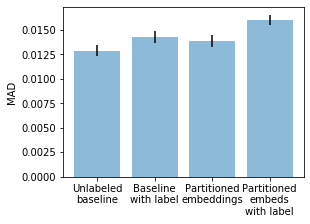

In [140]:
 models = ["Unlabeled\nbaseline", "Baseline\nwith label", "Partitioned\nembeddings", "Partitioned\nembeds\nwith label"]
x_pos = np.arange(len(models))
n_bootstraps = 50

means = [a.mean() for a in abs_diffs.values()]
bootstrapped_means = []
for a in abs_diffs.values():
    bs_means = []
    for _ in range(n_bootstraps):
        bs_means.append(np.random.choice(a, len(a)).mean())
    bootstrapped_means.append([np.quantile(bs_means, 0.025), np.quantile(bs_means,0.975)])
errors = np.array(bootstrapped_means).T

fig, ax = plt.subplots()
ax.bar(x_pos, means, yerr=np.abs(errors-means), align='center', alpha=0.5, ecolor='black')
ax.set_ylabel("MAD")
ax.set_xticks(x_pos)
ax.set_xticklabels(models)
#ax.set_ylim(bottom=0.8)

plt.tight_layout()
fig.set_size_inches(4, 3)
plt.savefig("imdb-k_50/mad-results.png", dpi=200)
plt.show()

In [ ]:
# pull out the most divergent
abs_diffs = pd.DataFrame.zeros([n_seeds, n_topics])
for seed, theta in thetas['imdb-k_50/learned_dev_no_bg-with_label'].items():
    theta_sent = np.array([
        theta[sentiment['neg'] == 1].mean(0),
        theta[sentiment['pos'] == 1].mean(0)
    ])

    abs_diffs[] = np.concatenate([abs_diffs, np.abs(theta_sent[1] - theta_sent[0])])
    print(f"{model:50} {abs_diffs.mean():0.5}")

In [10]:
theta_ttests = {}

for model, theta_by_seed in thetas.items():
    theta_ttests[model] = np.zeros(n_topics * n_seeds)
    for i, theta in enumerate(theta_by_seed.values()):
        for k in range(n_topics):
            t_stat, _ = stats.ttest_ind(
                theta[sentiment['neg'] == 1, k],
                theta[sentiment['pos'] == 1, k]
            )
            theta_ttests[model][(i * n_topics) + k] = np.abs(t_stat)
    print(f"{model:50} {theta_ttests[model].mean():0.5}")

imdb-k_50/baseline-learned_dev_learned_bg          0.0
imdb-k_50/baseline-learned_dev_no_bg-with_label    0.0
imdb-k_50/baseline-no_dev_learned_bg               16.616
imdb-k_50/baseline-no_dev_learned_bg-with_label    18.568
imdb-k_50/learned_dev_learned_bg                   0.0
imdb-k_50/learned_dev_no_bg                        18.31
imdb-k_50/learned_dev_no_bg-with_label             21.248


In [38]:
# count "significant differences" across all topics, across all seeds
theta_ttests = {}

for model, theta_by_seed in thetas.items():
    theta_ttests[model] = np.ones((n_seeds, n_topics))
    for i, theta in enumerate(theta_by_seed.values()):
        for k in range(n_topics):
            t_stat, p_val = stats.ttest_ind(
                theta[sentiment['neg'] == 1, k],
                theta[sentiment['pos'] == 1, k]
            )
            theta_ttests[model][i, k] = p_val
    significant_diffs = theta_ttests[model] < 1/(n_seeds * n_topics * 10)
    print(f"{model:50} {significant_diffs.sum()}")

imdb-k_50/baseline-learned_dev_learned_bg          0
imdb-k_50/baseline-learned_dev_no_bg-with_label    0
imdb-k_50/baseline-no_dev_learned_bg               661
imdb-k_50/baseline-no_dev_learned_bg-with_label    666
imdb-k_50/learned_dev_learned_bg                   0
imdb-k_50/learned_dev_no_bg                        662
imdb-k_50/learned_dev_no_bg-with_label             666


In [28]:
stats.ttest_ind(
                theta[sentiment['neg'] == 1, k],
                theta[sentiment['pos'] == 1, k]
            )

Ttest_indResult(statistic=-37.0129032654202, pvalue=5.348195341763185e-292)

In [ ]:
from sklearn.cluster import KMeans

for model, theta_by_seed in thetas.items():
    sse = []
    for theta in theta_by_seed.values():
        kmeans = KMeans(n_clusters=2)
        kmeans.fit_transform(theta)
        sse.append(kmeans.inertia_)

In [70]:
sentiment.neg

train_127      1
train_126      1
train_125      1
train_124      1
train_123      1
              ..
train_12420    0
train_12419    0
train_12418    0
train_12417    0
train_12416    0
Name: neg, Length: 25000, dtype: int64

In [97]:
from collections import defaultdict
from sklearn.linear_model import LogisticRegression

np.random.seed(11235)
n_docs = sentiment.shape[0]
train_idx = np.random.choice((False, True), n_docs, p=(0.2, 0.8))

data = defaultdict(list)
accuracy = defaultdict(list)

for model, theta_by_seed in thetas.items():
    if not theta_by_seed.values():
        continue
    for theta in theta_by_seed.values():
        #data[model].append(theta)
    #if data[model]:
        #x = np.concatenate(data[model], axis=1)
        x = theta
        x_train = x[train_idx]
        y_train = sentiment['pos'][train_idx]

        x_test = x[~train_idx]
        y_test = sentiment['pos'][~train_idx]#sentiment.loc[~train_idx, ['neg', 'pos']].values

        lr = LogisticRegression()
        lr.fit(x_train, y_train)
        #y_pred = lr.predict_log_proba(x_test)
        #loss = np.sum(y_test * y_pred, 1).mean()
        y_pred = lr.predict(x_test)
        accuracy[model].append(np.mean(y_test == y_pred))
    accuracy[model] = np.array(accuracy[model])
    print(f"{model:50} {accuracy[model].mean():0.3} ({accuracy[model].std():0.3})")

imdb-k_50/baseline-no_dev_learned_bg               0.826 (0.00534)
imdb-k_50/baseline-no_dev_learned_bg-with_label    0.885 (0.00455)
imdb-k_50/learned_dev_no_bg                        0.862 (0.00512)
imdb-k_50/learned_dev_no_bg-with_label             0.946 (0.00306)


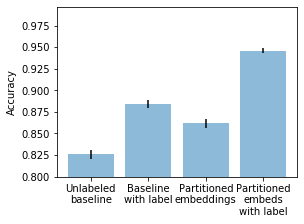

In [106]:
models = ["Unlabeled\nbaseline", "Baseline\nwith label", "Partitioned\nembeddings", "Partitioned\nembeds\nwith label"]
x_pos = np.arange(len(models))
means = [a.mean() for a in accuracy.values()]
stds = [a.std() for a in accuracy.values()]

fig, ax = plt.subplots()
ax.bar(x_pos, means, yerr=stds, align='center', alpha=0.5, ecolor='black')
ax.set_ylabel("Accuracy")
ax.set_xticks(x_pos)
ax.set_xticklabels(models)
ax.set_ylim(bottom=0.8)

plt.tight_layout()
fig.set_size_inches(4, 3)
plt.savefig("imdb-k_50/accuracy-results.png", dpi=200)
plt.show()